# LNP Internalization

- Imaging date: 2024-09-17

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bioio import BioImage
from scipy import ndimage as ndi
from skimage import io, filters, exposure, segmentation, morphology, measure, feature
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
plt.rcParams.update({
    'font.family': 'Arial',  # Times New Roman, Calibri
    'font.weight': 'normal',
    'mathtext.fontset': 'stixsans',
    'font.size': 18,

    'lines.linewidth': 2,

    'axes.linewidth': 2,
    'axes.spines.top': True,
    'axes.spines.right': True,
    'axes.titleweight': 'bold',
    'axes.titlesize': 18,
    'axes.labelweight': 'bold',

    'xtick.major.size': 8,
    'xtick.major.width': 2,
    'ytick.major.size': 8,
    'ytick.major.width': 2,

    'figure.dpi': 80,
    'savefig.dpi': 300,

    'legend.framealpha': 1,
    'legend.edgecolor': 'black',
    'legend.fancybox': False,
    'legend.fontsize': 14,

    'animation.html': 'html5',
})

## Tuning thresholding methods

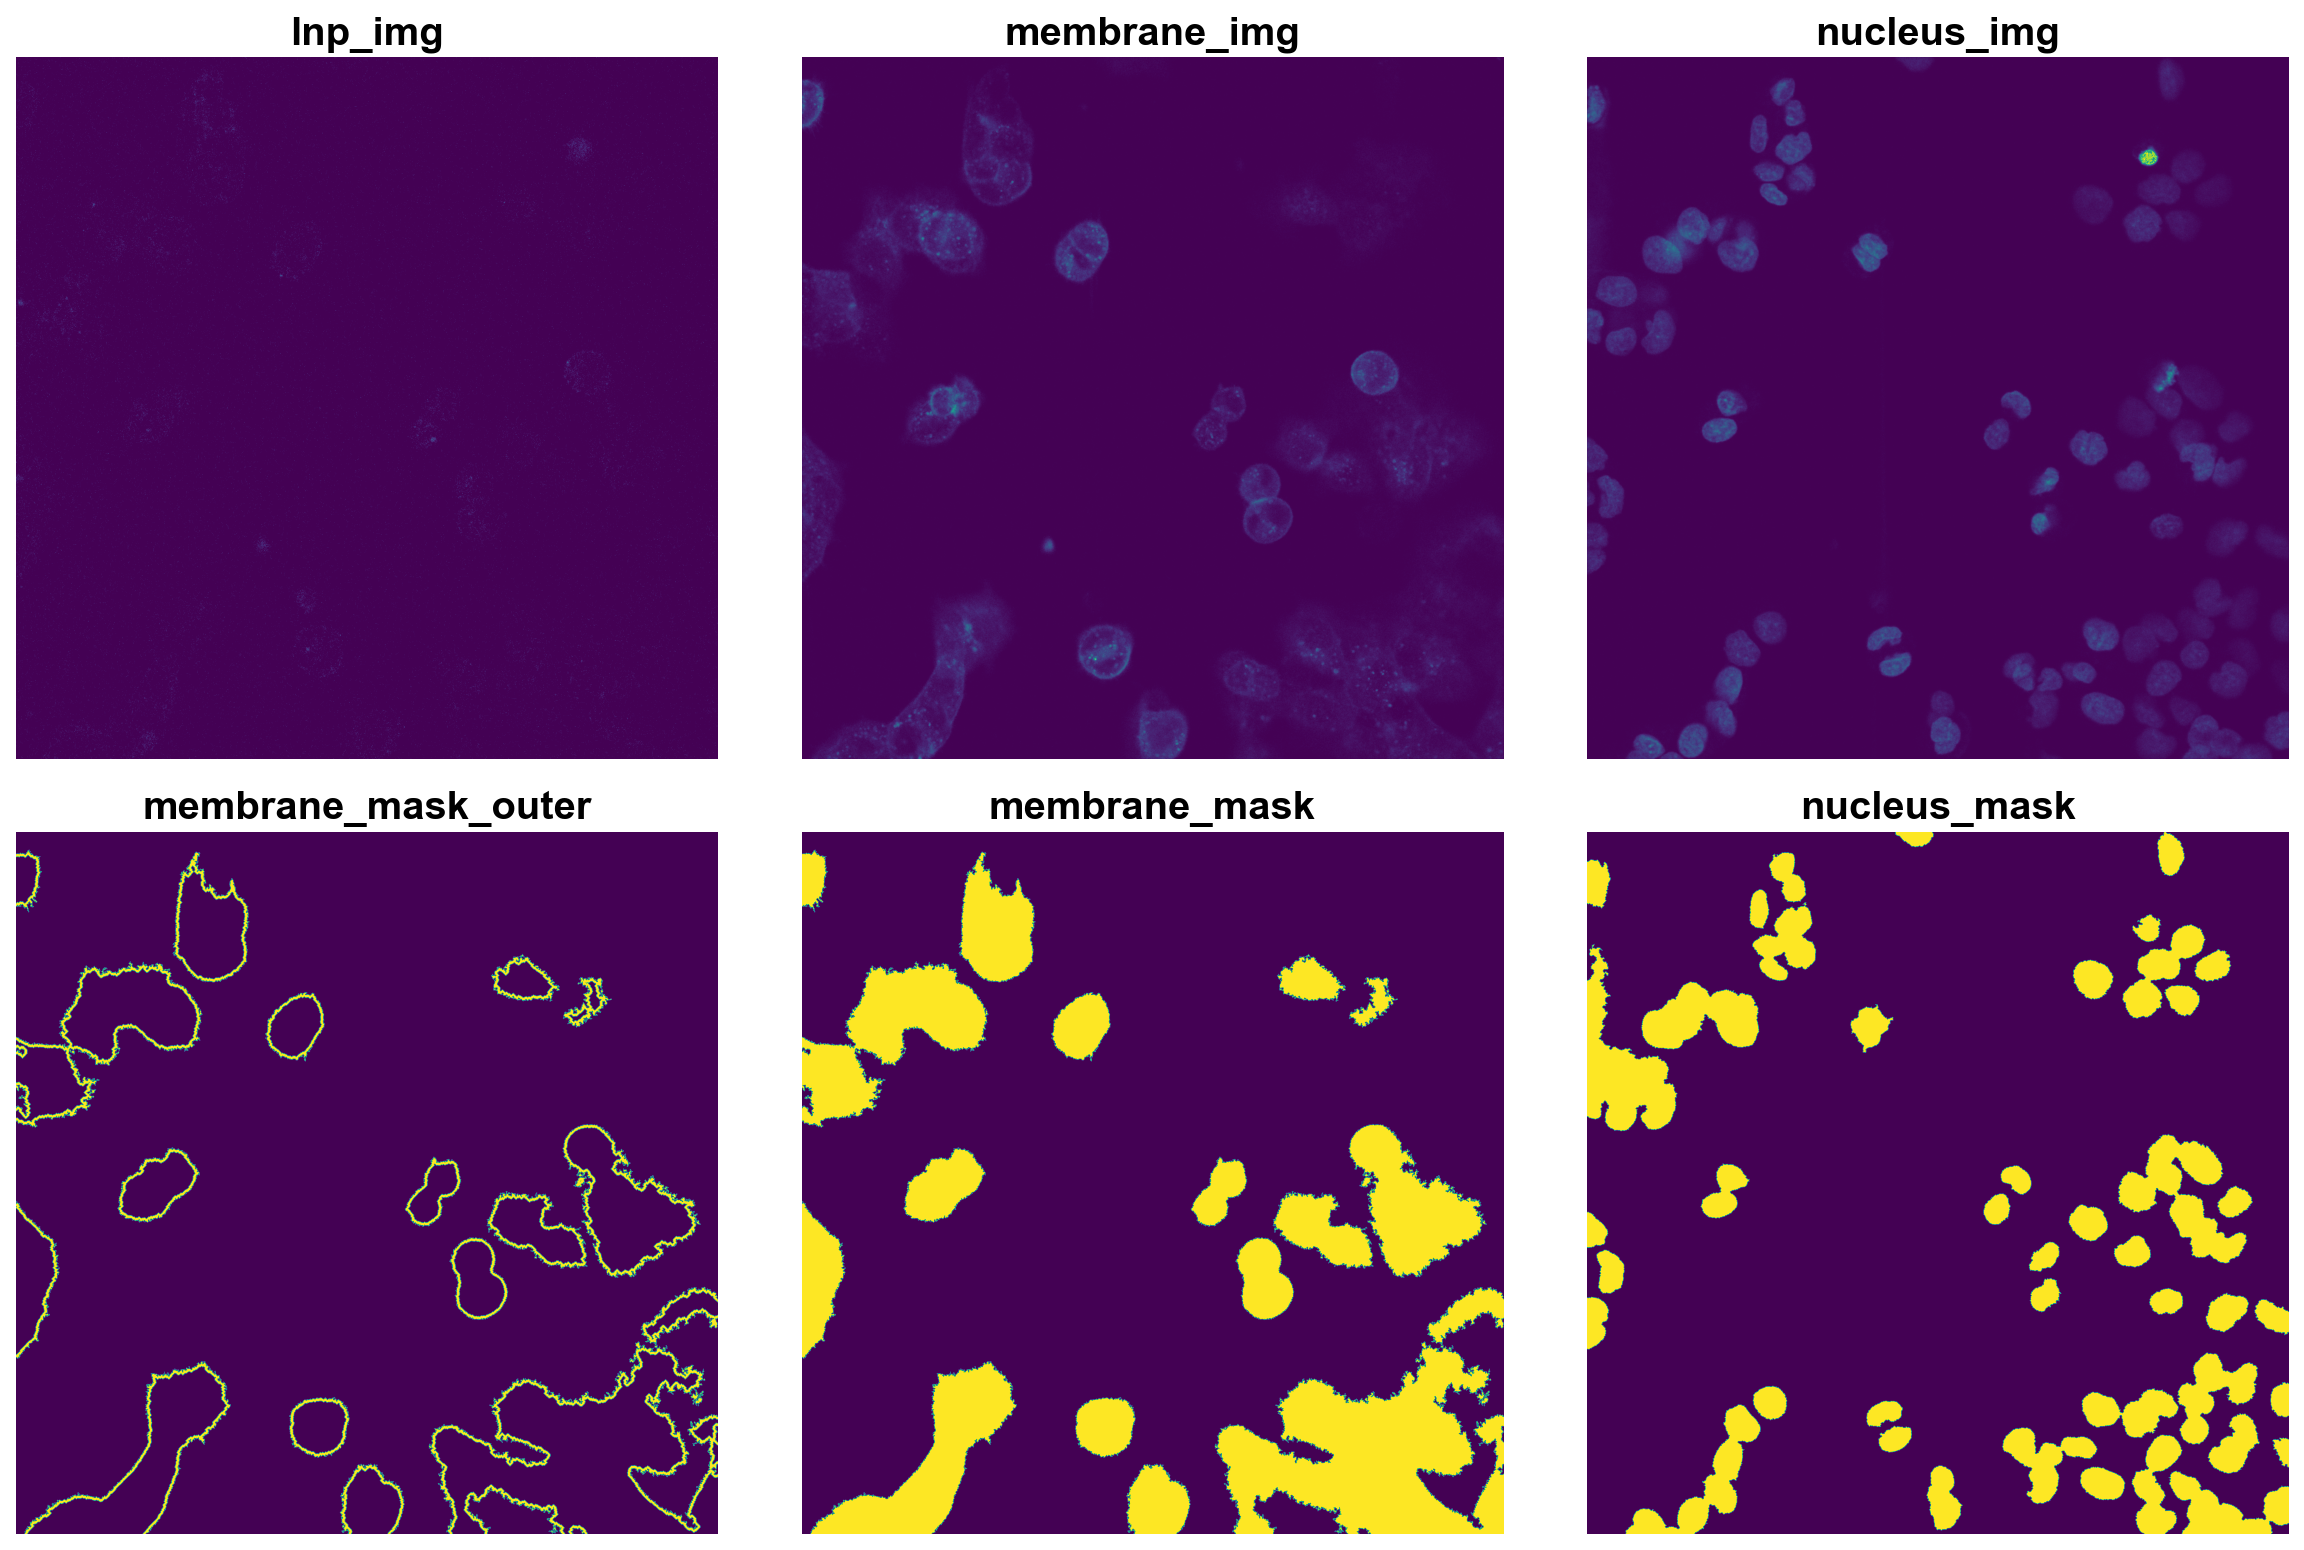

In [198]:
# Get a BioImage object
# img = BioImage("img_data/2024-09-17/exp_1_LNP_np.czi")
# img = BioImage("img_data/2024-09-17/exp_3_LNP_VTN.czi")
# img = BioImage("img_data/2024-09-17/exp_11_LNP_VTN.czi")
# img = BioImage("img_data/2024-09-17/exp_16_LNP_VTN.czi")
img = BioImage("img_data/2024-09-17/exp_4_cellonly_VTN.czi")
scene_idx = 0
img.set_scene(scene_idx)
lazy_t0 = img.get_image_dask_data("CYX")  # returns out-of-memory 4D dask array
t0 = lazy_t0.compute()  # returns in-memory 4D numpy array

img = t0.copy()
lnp_img = img[1, :, :]
membrane_img = img[3, :, :]
nucleus_img = img[5, :, :]

# membrane thresholding
# membrane_img_processed = exposure.equalize_hist(membrane_img)
# membrane_thresh = filters.threshold_local(
#     membrane_img_processed,
#     block_size=35,
#     offset=-6,
# )
membrane_thresh = filters.threshold_li(membrane_img)
membrane_mask = (membrane_img > membrane_thresh)
membrane_mask = morphology.remove_small_objects(membrane_mask, 3000)
membrane_mask = morphology.remove_small_holes(membrane_mask, 300)
membrane_mask = ndi.binary_fill_holes(membrane_mask)

# membrane inner region thresholding (by erosion 10 times)
membrane_mask_inner = morphology.erosion(membrane_mask)
for k in range(9):
    membrane_mask_inner = morphology.erosion(membrane_mask_inner)
membrane_mask_outer = np.bitwise_xor(membrane_mask_inner, membrane_mask)

# nucleus thresholding
nucleus_img_processed = exposure.equalize_hist(nucleus_img)
nucleus_thresh = filters.threshold_local(
    nucleus_img_processed,
    block_size=35,  # 35
    offset=-3,  # -15 is good for exp 3, -3 is good for exp 1
)
# nucleus_thresh = filters.threshold_otsu(nucleus_img)
nucleus_mask = (nucleus_img > nucleus_thresh)
nucleus_mask = ndi.binary_fill_holes(nucleus_mask)
nucleus_mask = morphology.remove_small_holes(nucleus_mask)
nucleus_mask = morphology.remove_small_objects(nucleus_mask, 500)
for k in range(2):
    nucleus_mask = morphology.erosion(nucleus_mask)
nucleus_mask = morphology.remove_small_objects(nucleus_mask, 2000)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs[0, 0].imshow(lnp_img)
axs[0, 1].imshow(membrane_img)
axs[0, 2].imshow(nucleus_img)
# axs[1, 0].imshow(membrane_mask_inner)
axs[1, 0].imshow(membrane_mask_outer)
axs[1, 1].imshow(membrane_mask)
axs[1, 2].imshow(nucleus_mask)

axs[0, 0].set_title('lnp_img')
axs[0, 1].set_title('membrane_img')
axs[0, 2].set_title('nucleus_img')
axs[1, 0].set_title('membrane_mask_outer')
axs[1, 1].set_title('membrane_mask')
axs[1, 2].set_title('nucleus_mask')

for i in range(2):
    for j in range(3):
        axs[i, j].axis('off')
plt.tight_layout()

In [4]:
labeled_nucleus = measure.label(nucleus_mask)
labeled_nucleus

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [5]:
props = measure.regionprops(labeled_nucleus, nucleus_img)

In [6]:
len(props)

31

In [7]:
props[0].area

6241.0

## Quantifying internalization

In [200]:
date = '2024-09-17'
dir_name = f'img_data/{date}'
filenames = np.array([
    'exp_1_LNP_np.czi',
    'exp_2_cellonly_np.czi',
    'exp_3_LNP_VTN.czi',
    'exp_4_cellonly_VTN.czi',
    'exp_5_LNP_A2M.czi',
    'exp_6_cellonly_A2M.czi',
    'exp_7_LNP_CR.czi',
    'exp_8_cellonly_CR.czi',
    'exp_9_cellonly_np.czi',
    'exp_10_LNP_np.czi',
    'exp_11_LNP_VTN.czi',
    'exp_12_LNP_A2M.czi',
    'exp_13_LNP_CR.czi',
    'exp_14_cellonly_np.czi',
    'exp_15_LNP_np.czi',
    'exp_16_LNP_VTN.czi',
    'exp_17_LNP_A2M.czi',
    'exp_18_LNP_CR.czi',
])

filename_list = []
scene_id_list = []
lnp_conc_list = []

lnp_intensity_list = []
nucleus_intensity_list = []
membrane_intensity_list = []

lnp_in_membrane_intensity_list = []
lnp_in_nucleus_intensity_list = []
lnp_in_membrane_intensity_per_membrane_list = []
lnp_in_nucleus_intensity_per_nucleus_list = []
lnp_in_membrane_binary_frac_list = []
lnp_in_nucleus_binary_frac_list = []
lnp_in_membrane_intensity_frac_list = []
lnp_in_nucleus_intensity_frac_list = []

lnp_in_inner_membrane_intensity_list = []
lnp_in_outer_membrane_intensity_list = []
lnp_in_inner_membrane_intensity_frac_list = []
lnp_in_outer_membrane_intensity_frac_list = []

membrane_count_list = []
nucleus_count_list = []

for j, filename in enumerate(filenames):
    filepath = os.path.join(dir_name, filename)
    raw_img = BioImage(filepath)
    for i in range(len(raw_img.scenes)):
        # store meta data
        filename_list.append(filename)
        scene_id_list.append(i)
        
        # set the scene of image - which technical sample to look at
        raw_img.set_scene(i)
        
        # load the image in
        lazy_t0 = raw_img.get_image_dask_data("CYX")  # returns out-of-memory 4D dask array
        t0 = lazy_t0.compute()  # returns in-memory 4D numpy array
        img = t0.copy()
        
        # split image by channels
        lnp_img = img[1, :, :]
        membrane_img = img[3, :, :]
        nucleus_img = img[5, :, :]

        ## get channel total intensities
        lnp_img_tot_intensity = lnp_img.sum()
        membrane_img_tot_intensity = membrane_img.sum()
        nucleus_img_tot_intensity = nucleus_img.sum()
        lnp_intensity_list.append(lnp_img_tot_intensity)
        nucleus_intensity_list.append(membrane_img_tot_intensity)
        membrane_intensity_list.append(nucleus_img_tot_intensity)

        ## per image co-localization analysis
        # threshold non-LNP (Cy5) channels
        # membrane_thresh = filters.threshold_li(membrane_img)
        # nucleus_thresh = filters.threshold_otsu(nucleus_img)
    
        ## by binary pixel
        # process each channel's binary masks
        # membrane thresholding
        membrane_thresh = filters.threshold_li(membrane_img)
        membrane_mask = (membrane_img > membrane_thresh)
        membrane_mask = morphology.remove_small_objects(membrane_mask, 3000)
        membrane_mask = morphology.remove_small_holes(membrane_mask, 300)
        membrane_mask = ndi.binary_fill_holes(membrane_mask)

        # membrane inner region thresholding (by erosion 10 times)
        membrane_mask_inner = morphology.erosion(membrane_mask)
        for k in range(9):
            membrane_mask_inner = morphology.erosion(membrane_mask_inner)
        membrane_mask_outer = np.bitwise_xor(membrane_mask_inner, membrane_mask)
        
        # nucleus thresholding
        nucleus_img_processed = exposure.equalize_hist(nucleus_img)
        nucleus_thresh = filters.threshold_local(
            nucleus_img_processed,
            block_size=35,  # 35
            offset=-3,  # -15 is good for exp 3
        )
        # nucleus_thresh = filters.threshold_otsu(nucleus_img)
        nucleus_mask = (nucleus_img > nucleus_thresh)
        nucleus_mask = ndi.binary_fill_holes(nucleus_mask)
        nucleus_mask = morphology.remove_small_holes(nucleus_mask)
        nucleus_mask = morphology.remove_small_objects(nucleus_mask, 500)
        for k in range(2):
            nucleus_mask = morphology.erosion(nucleus_mask)
        nucleus_mask = morphology.remove_small_objects(nucleus_mask, 2000)

        # cell count
        membrane_count = np.unique(measure.label(membrane_mask))[-1]
        nucleus_count = np.unique(measure.label(nucleus_mask))[-1]
        membrane_count_list.append(membrane_count)
        nucleus_count_list.append(nucleus_count)
        
        ## by intensity
        # process each channel's thresholded image with intensity (intensity within mask, 0 outside)
        lnp_in_membrane_img_thresh = lnp_img.copy()
        lnp_in_membrane_img_thresh[~membrane_mask] = 0
        
        lnp_in_nucleus_img_thresh = lnp_img.copy()
        lnp_in_nucleus_img_thresh[~nucleus_mask] = 0

        # calculate the total intensity within the boundary
        lnp_in_membrane_intensity = lnp_in_membrane_img_thresh.sum()
        lnp_in_nucleus_intensity = lnp_in_nucleus_img_thresh.sum()

        # calculate intensity within the boundary per boundary number
        lnp_in_membrane_intensity_per_membrane = lnp_in_membrane_intensity / membrane_count
        lnp_in_nucleus_intensity_per_nucleus = lnp_in_nucleus_intensity / nucleus_count
        
        # calculate fractions by intensity
        lnp_in_membrane_intensity_frac = lnp_in_membrane_intensity / lnp_img_tot_intensity
        lnp_in_nucleus_intensity_frac = lnp_in_nucleus_intensity / lnp_img_tot_intensity
        
        # store raw intensity and fractions
        lnp_in_membrane_intensity_list.append(lnp_in_membrane_intensity)
        lnp_in_nucleus_intensity_list.append(lnp_in_nucleus_intensity)
        lnp_in_membrane_intensity_per_membrane_list.append(lnp_in_membrane_intensity_per_membrane)
        lnp_in_nucleus_intensity_per_nucleus_list.append(lnp_in_nucleus_intensity_per_nucleus)
        lnp_in_membrane_intensity_frac_list.append(lnp_in_membrane_intensity_frac)
        lnp_in_nucleus_intensity_frac_list.append(lnp_in_nucleus_intensity_frac)

        # membrane inner/outer mask analysis
        lnp_in_inner_membrane_img_thresh = lnp_img.copy()
        lnp_in_inner_membrane_img_thresh[~membrane_mask_inner] = 0
        lnp_in_outer_membrane_img_thresh = lnp_img.copy()
        lnp_in_outer_membrane_img_thresh[~membrane_mask_outer] = 0

        lnp_in_inner_membrane_intensity = lnp_in_inner_membrane_img_thresh.sum()
        lnp_in_outer_membrane_intensity = lnp_in_outer_membrane_img_thresh.sum()
        lnp_in_inner_membrane_intensity_frac = lnp_in_inner_membrane_intensity / lnp_in_membrane_intensity
        lnp_in_outer_membrane_intensity_frac = lnp_in_outer_membrane_intensity / lnp_in_membrane_intensity

        lnp_in_inner_membrane_intensity_list.append(lnp_in_inner_membrane_intensity)
        lnp_in_outer_membrane_intensity_list.append(lnp_in_outer_membrane_intensity)
        lnp_in_inner_membrane_intensity_frac_list.append(lnp_in_inner_membrane_intensity_frac)
        lnp_in_outer_membrane_intensity_frac_list.append(lnp_in_outer_membrane_intensity_frac)

In [201]:
df = pd.DataFrame({
    'Filename': filename_list,
    'Scene ID': scene_id_list,
    
    'Total intensity LNP in entire img': lnp_intensity_list,
    'Total intensity nucleus in entire img': nucleus_intensity_list,
    'Total intensity membrane in entire img': membrane_intensity_list,

    'Intensity LNP in membrane mask': lnp_in_membrane_intensity_list,
    'Intensity LNP in nucleus mask': lnp_in_nucleus_intensity_list,
    'Intensity LNP per membrane count': lnp_in_membrane_intensity_per_membrane_list,
    'Intensity LNP per nucleus count': lnp_in_nucleus_intensity_per_nucleus_list,
    
    'Frac intensity LNP in membrane mask over img': lnp_in_membrane_intensity_frac_list,
    'Frac intensity LNP in nucleus mask over img': lnp_in_nucleus_intensity_frac_list,

    'Intensity LNP in membrane inner mask': lnp_in_inner_membrane_intensity_list,
    'Intensity LNP in membrane outer mask': lnp_in_outer_membrane_intensity_list,
    'Frac intensity LNP in membrane inner mask over membrane mask': lnp_in_inner_membrane_intensity_frac_list,
    'Frac intensity LNP in membrane outer mask over membrane mask': lnp_in_outer_membrane_intensity_frac_list,

    'Membrane count': membrane_count_list,
    'Nucleus count': nucleus_count_list,
})
df

,Filename,Scene ID,Total intensity LNP in entire img,Total intensity nucleus in entire img,Total intensity membrane in entire img,Intensity LNP in membrane mask,Intensity LNP in nucleus mask,Intensity LNP per membrane count,Intensity LNP per nucleus count,Frac intensity LNP in membrane mask over img,Frac intensity LNP in nucleus mask over img,Intensity LNP in membrane inner mask,Intensity LNP in membrane outer mask,Frac intensity LNP in membrane inner mask over membrane mask,Frac intensity LNP in membrane outer mask over membrane mask,Membrane count,Nucleus count
0,exp_1_LNP_np.czi,0,2170517,11580895,4113451,645792,267615,33989.052632,10292.884615,0.297529,0.123296,541978,103814,0.839245,0.160755,19,26
1,exp_1_LNP_np.czi,1,2476863,24007616,6643688,990352,413434,61897.000000,11812.400000,0.399841,0.166918,866691,123661,0.875134,0.124866,16,35
2,exp_1_LNP_np.czi,2,2585159,26000585,8196553,1130430,428442,59496.315789,10711.050000,0.437277,0.165731,980427,150003,0.867304,0.132696,19,40
3,exp_1_LNP_np.czi,3,2310328,30273606,13382576,895634,500997,40710.636364,12524.925000,0.387665,0.216851,768247,127387,0.857769,0.142231,22,40
4,exp_1_LNP_np.czi,4,2619181,32926922,8799630,1160633,523455,96719.416667,14540.416667,0.443128,0.199854,1032963,127670,0.890000,0.110000,12,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,exp_18_LNP_CR.czi,7,5364561,44662590,23804523,944401,337421,62960.066667,28118.416667,0.176044,0.062898,591296,353105,0.626107,0.373893,15,12
212,exp_18_LNP_CR.czi,8,3489386,47312881,32886433,922874,801430,41948.818182,29682.592593,0.264480,0.229677,760247,162627,0.823782,0.176218,22,27
213,exp_18_LNP_CR.czi,9,3846929,71529981,25353175,1027180,534270,93380.000000,29681.666667,0.267013,0.138882,849251,177929,0.826779,0.173221,11,18
214,exp_18_LNP_CR.czi,10,5889906,76253107,26070755,1373773,1112999,76320.722222,61833.277778,0.233242,0.188967,1034927,338846,0.753346,0.246654,18,18


In [204]:
# membrane threshold upgrade
# ApoE img + neg control, see if thresholding method holds
# nucleus thresholding, membrane-nucleus colocalization - check for live cells

df.tail(20)

,Filename,Scene ID,Total intensity LNP in entire img,Total intensity nucleus in entire img,Total intensity membrane in entire img,Intensity LNP in membrane mask,Intensity LNP in nucleus mask,Intensity LNP per membrane count,Intensity LNP per nucleus count,Frac intensity LNP in membrane mask over img,Frac intensity LNP in nucleus mask over img,Intensity LNP in membrane inner mask,Intensity LNP in membrane outer mask,Frac intensity LNP in membrane inner mask over membrane mask,Frac intensity LNP in membrane outer mask over membrane mask,Membrane count,Nucleus count
196,exp_17_LNP_A2M.czi,4,2707305,92176950,33316553,961266,417882,64084.400000,18994.636364,0.355064,0.154353,846610,114656,0.880724,0.119276,15,22
197,exp_17_LNP_A2M.czi,5,2631581,66305326,21552326,920597,391521,41845.318182,18643.857143,0.349827,0.148778,749717,170880,0.814381,0.185619,22,21
198,exp_17_LNP_A2M.czi,6,2015718,54768721,17384667,517017,264162,34467.800000,16510.125000,0.256493,0.131051,417880,99137,0.808252,0.191748,15,16
199,exp_17_LNP_A2M.czi,7,2594029,73318837,25945185,981288,606537,70092.000000,30326.850000,0.378287,0.233820,851126,130162,0.867356,0.132644,14,20
200,exp_17_LNP_A2M.czi,8,2559105,87329139,30689277,945385,564757,59086.562500,21721.423077,0.369420,0.220685,787639,157746,0.833141,0.166859,16,26
201,exp_17_LNP_A2M.czi,9,2215828,102050824,19710919,692179,279827,46145.266667,15545.944444,0.312379,0.126286,598030,94149,0.863982,0.136018,15,18
202,exp_17_LNP_A2M.czi,10,2840173,65599518,14519670,576420,228126,48035.000000,19010.500000,0.202952,0.080321,501290,75130,0.869661,0.130339,12,12
203,exp_17_LNP_A2M.czi,11,3469626,80795171,16133637,747505,323255,57500.384615,19015.000000,0.215443,0.093167,627305,120200,0.839198,0.160802,13,17
204,exp_18_LNP_CR.czi,0,3504238,45245681,16964187,465290,237549,42299.090909,14846.812500,0.132779,0.067789,391494,73796,0.841398,0.158602,11,16
205,exp_18_LNP_CR.czi,1,4607033,78199866,24535224,1077615,787638,63389.117647,32818.250000,0.233907,0.170964,945944,131671,0.877813,0.122187,17,24


In [205]:
df_filename = os.path.join(f'processed_data/{date}', f"df.csv")
df.to_csv(df_filename)

### Filter for membrane and nucleus count

In [235]:
# filtered_df = df[(df['Nucleus count'] >= 5)]
filtered_df = df.copy()

In [236]:
filtered_df_filename = os.path.join(f'processed_data/{date}', f"filtered_df.csv")
filtered_df.to_csv(filtered_df_filename)

### Summary statistics by scene

In [237]:
summary_df = filtered_df.groupby('Filename').describe()
summary_df

Scene ID                                             \
                          count mean       std  min   25%  50%   75%   max   
Filename                                                                     
exp_10_LNP_np.czi          12.0  5.5  3.605551  0.0  2.75  5.5  8.25  11.0   
exp_11_LNP_VTN.czi         12.0  5.5  3.605551  0.0  2.75  5.5  8.25  11.0   
exp_12_LNP_A2M.czi         12.0  5.5  3.605551  0.0  2.75  5.5  8.25  11.0   
exp_13_LNP_CR.czi          12.0  5.5  3.605551  0.0  2.75  5.5  8.25  11.0   
exp_14_cellonly_np.czi     12.0  5.5  3.605551  0.0  2.75  5.5  8.25  11.0   
exp_15_LNP_np.czi          12.0  5.5  3.605551  0.0  2.75  5.5  8.25  11.0   
exp_16_LNP_VTN.czi         12.0  5.5  3.605551  0.0  2.75  5.5  8.25  11.0   
exp_17_LNP_A2M.czi         12.0  5.5  3.605551  0.0  2.75  5.5  8.25  11.0   
exp_18_LNP_CR.czi          12.0  5.5  3.605551  0.0  2.75  5.5  8.25  11.0   
exp_1_LNP_np.czi           12.0  5.5  3.605551  0.0  2.75  5.5  8.25  11.0   
exp_2_cellonly_np.czi      12.0  5.5  3.605551  0.0  2.75  5.5  8.25  11.0   
exp_3_LNP_VTN.czi          12.0  5.5  3.605551  0.0  2.75  5.5  8.25  11.0   
exp_4_cellonly_VTN.czi     12.0  5.5  3.605551  0.0  2.75  5.5  8.25  11.0   
exp_5_LNP_A2M.czi          12.0  5.5  3.605551  0.0  2.75  5.5  8.25  11.0   
exp_6_cellonly_A2M.czi     12.0  5.5  3.605551  0.0  2.75  5.5  8.25  11.0   
exp_7_LNP_CR.czi           12.0  5.5  3.605551  0.0  2.75  5.5  8.25  11.0   
exp_8_cellonly_CR.czi      12.0  5.5  3.605551  0.0  2.75  5.5  8.25  11.0   
exp_9_cellonly_np.czi      12.0  5.5  3.605551  0.0  2.75  5.5  8.25  11.0   

                       Total intensity LNP in entire img                ...  \
                                                   count          mean  ...   
Filename                                                                ...   
exp_10_LNP_np.czi                                   12.0  2.451112e+06  ...   
exp_11_LNP_VTN.czi                                  12.0  6.138734e+06  ...   
exp_12_LNP_A2M.czi                                  12.0  2.547648e+06  ...   
exp_13_LNP_CR.czi                                   12.0  3.183810e+06  ...   
exp_14_cellonly_np.czi                              12.0  3.173934e+05  ...   
exp_15_LNP_np.czi                                   12.0  2.410108e+06  ...   
exp_16_LNP_VTN.czi                                  12.0  3.999359e+06  ...   
exp_17_LNP_A2M.czi                                  12.0  2.503595e+06  ...   
exp_18_LNP_CR.czi                                   12.0  4.102512e+06  ...   
exp_1_LNP_np.czi                                    12.0  2.405204e+06  ...   
exp_2_cellonly_np.czi                               12.0  2.113975e+05  ...   
exp_3_LNP_VTN.czi                                   12.0  5.526838e+06  ...   
exp_4_cellonly_VTN.czi                              12.0  3.321144e+05  ...   
exp_5_LNP_A2M.czi                                   12.0  2.335966e+06  ...   
exp_6_cellonly_A2M.czi                              12.0  3.190096e+05  ...   
exp_7_LNP_CR.czi                                    12.0  2.883622e+06  ...   
exp_8_cellonly_CR.czi                               12.0  3.261739e+05  ...   
exp_9_cellonly_np.czi                               12.0  2.710622e+05  ...   

                       Membrane count       Nucleus count             \
                                  75%   max         count       mean   
Filename                                                               
exp_10_LNP_np.czi               23.00  29.0          12.0  27.166667   
exp_11_LNP_VTN.czi              19.50  23.0          12.0  22.833333   
exp_12_LNP_A2M.czi              22.25  24.0          12.0  27.583333   
exp_13_LNP_CR.czi               21.25  23.0          12.0  25.916667   
exp_14_cellonly_np.czi          22.00  25.0          12.0  26.333333   
exp_15_LNP_np.czi               21.00  26.0          12.0  24.750000   
exp_16_LNP_VTN.czi              17.00  19.0          12.0  16.416667   
exp_

In [238]:
summary_df_filename = os.path.join(f'processed_data/{date}', f"summary_df.csv")
summary_df.to_csv(summary_df_filename)

### Transform dataframe for GraphPad Prism by scene

In [239]:
max_sample_size = df['Scene ID'].max() + 1
exp_group_size = len(filenames)

In [240]:
property_array = np.zeros((max_sample_size, exp_group_size))
property_array.fill(np.nan)
property_array

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan,

In [241]:
property_list = [
    'Total intensity LNP in entire img',
    'Total intensity nucleus in entire img',
    'Total intensity membrane in entire img',

    'Intensity LNP in membrane mask',
    'Intensity LNP in nucleus mask',
    'Intensity LNP per membrane count',
    'Intensity LNP per nucleus count',
    
    'Frac intensity LNP in membrane mask over img',
    'Frac intensity LNP in nucleus mask over img',

    'Intensity LNP in membrane inner mask',
    'Intensity LNP in membrane outer mask',
    'Frac intensity LNP in membrane inner mask over membrane mask',
    'Frac intensity LNP in membrane outer mask over membrane mask',

    'Membrane count',
    'Nucleus count',
]

In [242]:
exp_prop_list = []
for property in property_list:
    for exp_i, filename in enumerate(filenames):
        data = df.loc[df['Filename'] == filename, property].values
        sample_size = len(data)
        property_array[:sample_size, exp_i] = data
        property_array_filename = os.path.join(f'processed_data/{date}/scene', f'{property}.csv')
        np.savetxt(property_array_filename, property_array, delimiter=",")

In [243]:
pd.Series(filenames).to_csv(f'processed_data/{date}/exp_groups.csv')

### Transform dataframe for GraphPad Prism by technical replicates

Each experiment has 4 technical replicates, grouped by 3 scenes.

In [244]:
num_scene = 3
num_tech_rep = 4

In [245]:
filtered_df['Technical replicate ID'] = np.array(list(np.array([[i] * num_scene for i in range(1, num_tech_rep+1)]).reshape(-1)) * exp_group_size)
filtered_df_tech = filtered_df.groupby(['Filename', 'Technical replicate ID']).mean().reset_index()
filtered_df_tech.head()

,Filename,Technical replicate ID,Scene ID,Total intensity LNP in entire img,Total intensity nucleus in entire img,Total intensity membrane in entire img,Intensity LNP in membrane mask,Intensity LNP in nucleus mask,Intensity LNP per membrane count,Intensity LNP per nucleus count,Frac intensity LNP in membrane mask over img,Frac intensity LNP in nucleus mask over img,Intensity LNP in membrane inner mask,Intensity LNP in membrane outer mask,Frac intensity LNP in membrane inner mask over membrane mask,Frac intensity LNP in membrane outer mask over membrane mask,Membrane count,Nucleus count
0,exp_10_LNP_np.czi,1,1.0,2.086837e+06,3.179334e+07,1.090142e+07,6.581150e+05,3.881067e+05,42942.828261,19027.802646,0.287649,0.169127,5.633440e+05,94771.000000,0.848212,0.151788,15.000000,23.666667
1,exp_10_LNP_np.czi,2,4.0,2.270849e+06,3.990352e+07,2.507095e+07,7.100733e+05,5.567073e+05,36609.766566,18188.108489,0.297944,0.227379,5.955580e+05,114515.333333,0.830331,0.169669,19.333333,28.333333
2,exp_10_LNP_np.czi,3,7.0,2.642854e+06,6.074956e+07,2.730027e+07,1.108912e+06,7.873823e+05,52147.916836,27827.655628,0.418574,0.294091,9.194577e+05,189454.333333,0.833343,0.166657,22.000000,28.333333
3,exp_10_LNP_np.czi,4,10.0,2.803906e+06,7.703212e+07,2.108690e+07,1.158531e+06,6.791493e+05,56282.073928,24242.197731,0.409477,0.239576,9.877993e+05,170731.333333,0.849682,0.150318,21.000000,28.333333
4,exp_11_LNP_VTN.czi,1,1.0,6.096429e+06,2.770319e+07,2.179714e+07,3.600650e+06,2.150017e+06,214776.503289,84231.724697,0.562893,0.334029,2.866766e+06,733884.000000,0.781559,0.218441,16.666667,25.000000


In [246]:
property_array = np.zeros((num_tech_rep, exp_group_size))
property_array.fill(np.nan)
property_array

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan]])

In [247]:
exp_prop_list = []
for property in property_list:
    for exp_i, filename in enumerate(filenames):
        data = filtered_df_tech.loc[filtered_df_tech['Filename'] == filename, property].values
        sample_size = len(data)
        property_array[:sample_size, exp_i] = data
        property_array_filename = os.path.join(f'processed_data/{date}/tech_rep', f'{property}.csv')
        np.savetxt(property_array_filename, property_array, delimiter=",")

## Visualizing thresholding

In [14]:
def save_img(img, img_label):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'{img_label}\n{filename}, S{i}', fontsize=12)
    fig_filepath = os.path.join(f'processed_img/{date}', f'{filename}_s{i}_{img_label}.png')
    fig.savefig(fig_filepath)
    plt.close()

In [15]:
for j, filename in enumerate(filenames):
    filepath = os.path.join(dir_name, filename)
    raw_img = BioImage(filepath)
    for i in range(len(raw_img.scenes)):
        # set the scene of image - which technical sample to look at
        raw_img.set_scene(i)
        
        # load the image in
        lazy_t0 = raw_img.get_image_dask_data("CYX")  # returns out-of-memory 4D dask array
        t0 = lazy_t0.compute()  # returns in-memory 4D numpy array
        img = t0.copy()
        
        # split image by channels
        lnp_img = img[1, :, :]
        membrane_img = img[3, :, :]
        nucleus_img = img[5, :, :]

        ## per image co-localization analysis
        # threshold non-LNP (Cy5) channels
        membrane_thresh = filters.threshold_li(membrane_img)
        nucleus_thresh = filters.threshold_otsu(nucleus_img)
    
        ## by binary pixel
        # process each channel's binary masks        
        membrane_mask = (membrane_img > membrane_thresh)
        membrane_mask = morphology.remove_small_objects(membrane_mask, 3000)
        membrane_mask = morphology.remove_small_holes(membrane_mask, 300)
        membrane_mask = ndi.binary_fill_holes(membrane_mask)
        
        nucleus_mask = (nucleus_img > nucleus_thresh)
        nucleus_mask = ndi.binary_fill_holes(nucleus_mask)
        nucleus_mask = segmentation.clear_border(nucleus_mask)
        nucleus_mask = morphology.remove_small_holes(nucleus_mask)
        nucleus_mask = morphology.remove_small_objects(nucleus_mask, 5000)
        
        ## by intensity
        # process each channel's thresholded image with intensity (intensity within mask, 0 outside)
        lnp_in_membrane_img_thresh = lnp_img.copy()
        lnp_in_membrane_img_thresh[~membrane_mask] = 0
        
        lnp_in_nucleus_img_thresh = lnp_img.copy()
        lnp_in_nucleus_img_thresh[~nucleus_mask] = 0

        save_img(lnp_img, 'lnp_img')
        save_img(nucleus_img, 'nucleus_img')
        save_img(membrane_img, 'membrane_img')
        
        save_img(membrane_mask, 'membrane_mask')
        save_img(nucleus_mask, 'nucleus_mask')
        
        save_img(lnp_in_membrane_img_thresh, 'lnp_in_membrane_img_thresh')
        save_img(lnp_in_nucleus_img_thresh, 'lnp_in_nucleus_img_thresh')